# Performance test of various implemenations of Dijkstra's Shortest Path Algorithm

Dijkstra's Algorithm provides the shortest sequence of nodes to go from a `source node` to a `target node` on a weighted, undirected graph.  This notebook will compare several implementations of Dijkstra's in Python.  A simple explanation of Dijkstra's method is availble in the following video:

In [56]:
from IPython.display import YouTubeVideo

YouTubeVideo('gdmfOwyQlcI')

Each implementation will be tested on the following graph:

In [45]:
graph = {'a': {'w': 14, 'x': 7, 'y': 9},
            'b': {'w': 9, 'z': 6},
            'w': {'a': 14, 'b': 9, 'y': 2},
            'x': {'a': 7, 'y': 10, 'z': 15},
            'y': {'a': 9, 'w': 2, 'x': 10, 'z': 11},
            'z': {'b': 6, 'x': 15, 'y': 11}}

We'll visualize this with `networkx`.  Later, we'll test networkX's performance as well.

Populating the interactive namespace from numpy and matplotlib


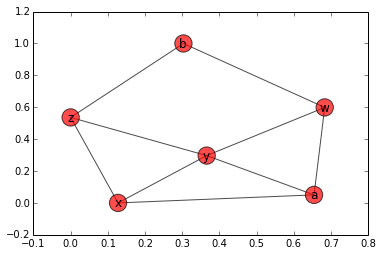

In [46]:
%pylab inline
import networkx as nwx
nxgraph = nwx.Graph(graph) #nwx imposes its own Graph class
nwx.draw_networkx(nxgraph, 
                  alpha=0.7,
                  with_labels=True);

### Method 1: [RebrainedBlog](http://rebrained.com/?p=392)

In [47]:
import sys

def m1_shortpath(graph,start,end,visited=[],distances={},predecessors={}):
    """Find the shortest path between start and end nodes in a graph"""
    # we've found our end node, now find the path to it, and return
    if start==end:
        path=[]
        while end != None:
            path.append(end)
            end=predecessors.get(end,None)
        return distances[start], path[::-1]
    # detect if it's the first time through, set current distance to zero
    if not visited: distances[start]=0
    # process neighbors as per algorithm, keep track of predecessors
    for neighbor in graph[start]:
        if neighbor not in visited:
            neighbordist = distances.get(neighbor,sys.maxint)
            tentativedist = distances[start] + graph[start][neighbor]
            if tentativedist < neighbordist:
                distances[neighbor] = tentativedist
                predecessors[neighbor]=start
    # neighbors processed, now mark the current node as visited
    visited.append(start)
    # finds the closest unvisited node to the start
    unvisiteds = dict((k, distances.get(k,sys.maxint)) for k in graph if k not in visited)
    closestnode = min(unvisiteds, key=unvisiteds.get)
    # now we can take the closest node and recurse, making it current
    return m1_shortpath(graph,closestnode,end,visited,distances,predecessors)

# Method 2: Chris Laffa/Connelly Barns [see here](http://code.activestate.com/recipes/119466-dijkstras-algorithm-for-shortest-paths/#c6)

In [48]:
import heapq

def m2_shortpath(graph, start, end):
    queue = [(0, start, [])]
    seen = set()
    while True:
        (cost, v, path) = heapq.heappop(queue)
        if v not in seen:
            path = path + [v]
            seen.add(v)
            if v == end:
                return cost, path
            for (next, c) in graph[v].iteritems():
                heapq.heappush(queue, (cost + c, next, path))

# Method 3: [NVictus pqdict package](https://gist.github.com/nvictus/7854213) 

In [49]:
import pqdict 

def dijkstra(graph, source, target=None):
    """
    Computes the shortests paths from a source vertex to every other vertex in
    a graph
    """
    # The entire main loop is O( (m+n) log n ), where n is the number of
    # vertices and m is the number of edges. If the graph is connected
    # (i.e. the graph is in one piece), m normally dominates over n, making the
    # algorithm O(m log n) overall.

    dist = {}   
    pred = {}

    # Store distance scores in a priority queue dictionary
    pq = pqdict.PQDict()
    for node in graph:
        if node == source:
            pq[node] = 0
        else:
            pq[node] = float('inf')

    # Remove the head node of the "frontier" edge from pqdict: O(log n).
    for node, min_dist in pq.iteritems():
        # Each node in the graph gets processed just once.
        # Overall this is O(n log n).
        dist[node] = min_dist
        if node == target:
            break

        # Updating the score of any edge's node is O(log n) using pqdict.
        # There is _at most_ one score update for each _edge_ in the graph.
        # Overall this is O(m log n).
        for neighbor in graph[node]:
            if neighbor in pq:
                new_score = dist[node] + graph[node][neighbor]
                if new_score < pq[neighbor]:
                    pq[neighbor] = new_score
                    pred[neighbor] = node

    return dist, pred

def m3_shortpath(graph, source, target):
    dist, pred = dijkstra(graph, source, target)
    end = target
    path = [end]
    while end != source:
        end = pred[end]
        path.append(end)        
    path.reverse()
    return path

### Implementation 1: Rebrained 

**<font color="red">`%%timeit` freezes using this algorithm.  %%timeit may be incompatible with recursive function.</font>**

In [50]:
#%%timeit
#m1_shortpath(graph,'a','b')

### Implementation 2: Barnes

In [51]:
%%timeit
m2_shortpath(graph,'a','b')

The slowest run took 5.17 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 27.9 µs per loop


### Implementation 3: NVictus

In [52]:
%%timeit
m3_shortpath(graph,'a','b')

10000 loops, best of 3: 170 µs per loop


### Implementation 4: NetworkX

In [53]:
%%timeit
nwx.shortest_path(nxgraph)

10000 loops, best of 3: 86.5 µs per loop


# Summary

Method2, using Python's `heapq` datastructure was the fastest of the three tested implementations; it also had very compact, nice code. NetworkX was still fast, despite being very flexible.  I thought networkX would add more overhead than this.   This summary is not exhaustive in either methods, nor test cases (ie bigger/different graphs).

While the nodes were strings, in principle, they could by any valid Python `dict` key type.  I've confirmed that implementation 2 works with [named tuples](http://pymotw.com/2/collections/namedtuple.html) as nodes, for example.